# Cartpole Environment

Vamos implementar o algoritmo REINFORCE no ambiente Cartpole-v0, no qual o objetivo é controlar a aceleração de um carro para equilibrar um pendulo invertido na posiçaõ vertical pelo maior tempo possível.

https://gym.openai.com/envs/CartPole-v1/

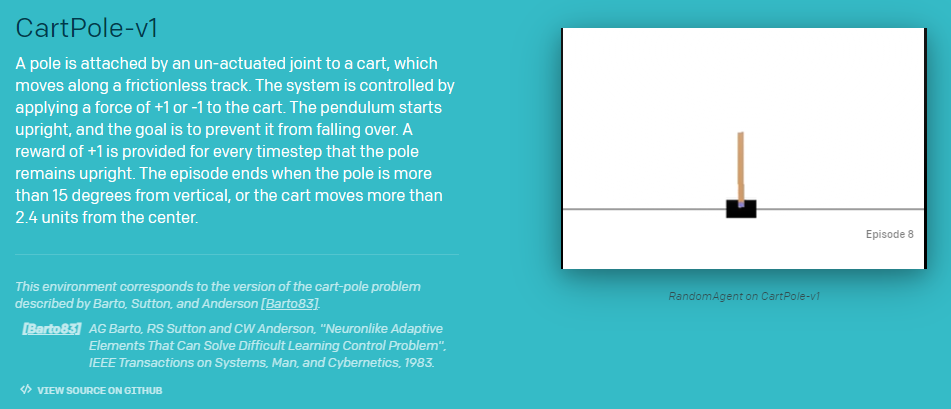

## Instalação de bibliotecas e Imports

In [1]:
!pip install keras-rl2

     |████████████████████████████████| 61kB 3.2MB/s 


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Global Variables

In [3]:
ENV_NAME="CartPole-v0"      # Environment Name
#ENV_NAME="Acrobot-v1"
RANDOM_SEED = 42            # Random Seed (For Reproducibility)
N_EPISODES = 400            # Total Number of Episodes
GAMMA = 0.99                # Discount Factor
ALPHA = 1e-4                # PG Learning Rate

## Criação de Ambiente

In [4]:
# set random seed (reproduciblity)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# create environment
env = gym.make(ENV_NAME) # env to import
env.seed(RANDOM_SEED)
env.reset() # reset to env

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

# REINFORCE

## Monte-Carlo Policy Gradient (REINFORCE) agent class

In [5]:
class REINFORCE:
  def __init__(self, env, path=None):
    self.env=env #import env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.gamma=GAMMA # decay rate of past observations
    self.alpha=ALPHA # learning rate in the policy gradient
    self.learning_rate=0.01 # learning rate in deep learning optimizer
    
    if not path:
      self.model=self._create_model() #build model
    else:
      self.model=self.load_model(path) #import model

    # record observations
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]
  
  def _create_model(self):
    ''' builds the model using keras'''
    # Build Model pi_theta
    model=Sequential()
    # Input Layer and Hidden Layers
    model.add(Dense(16, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(16, activation="relu"))
    # Output Layer
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(lr=self.learning_rate))
        
    return model

  def hot_encode_action(self, action):
    '''encoding the actions into a binary list'''

    action_encoded=np.zeros(self.action_shape, np.float32)
    action_encoded[action]=1

    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    '''stores observations'''
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  
  def get_action(self, state):
    '''samples the next action based on the policy probabilty distribution 
      of the actions'''

    # transform state
    state=state.reshape([1, state.shape[0]])
    # get action probably
    action_probability_distribution=self.model.predict(state).flatten()
    # norm action probability distribution
    action_probability_distribution/=np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution


  def get_discounted_rewards(self, rewards): 
    '''Use gamma to calculate the total reward discounting for rewards
    Following - \gamma ^ t * Gt'''
    
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards


  def update_policy(self):
    '''Updates the policy network using the NN model.
    This function is used after the MC sampling is done - following
    \delta \theta = \alpha * gradient + log pi'''
      
    # get X
    states=np.vstack(self.states)

    # get Y
    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs

    # Update Actor
    history=self.model.train_on_batch(states, gradients)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

    return history



  def simulate_N_episodes(self,N_episodes):

      episode_rewards = []
      for episode in range(N_episodes):

        state = env.reset()
        done = False          
        episode_reward = 0 # record episode reward

        while not done:
            # play an action and record the game state & reward per episode
            action, prob = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            self.remember(state, action, prob, reward)
            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
      
      return np.mean(episode_rewards)



  def train(self, episodes, rollout_n=1):
    '''train the model
        episodes - number of training iterations 
        rollout_n- number of episodes between policy update''' 
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      print('----------------------------------')
      print('episode = ' + str(episode))

      # Simulate rollout_n episodes
      total_episode_reward = self.simulate_N_episodes(N_episodes=rollout_n)

      # Update Policy
      self.update_policy()

      total_rewards[episode] = total_episode_reward
      print('Total Reward = ' + str(total_episode_reward))
      
    self.total_rewards = total_rewards

  def save_model(self):
    '''saves the moodel // do after training'''
    self.model.save('REINFORCE_model.h5')
  
  def load_model(self, path):
    '''loads a trained model from path'''
    return load_model(path)

## Create REINFORCE agent and train

In [6]:
# Create agent and train the model

REINFORCE_agent = REINFORCE(env)
REINFORCE_agent.train(N_EPISODES, rollout_n=1)

----------------------------------
episode = 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Total Reward = 41.0
----------------------------------
episode = 1
Total Reward = 12.0
----------------------------------
episode = 2
Total Reward = 21.0
----------------------------------
episode = 3
Total Reward = 21.0
----------------------------------
episode = 4
Total Reward = 10.0
----------------------------------
episode = 5
Total Reward = 16.0
----------------------------------
episode = 6
Total Reward = 15.0
----------------------------------
episode = 7
Total Reward = 17.0
----------------------------------
episode = 8
Total Reward = 22.0
----------------------------------
episode = 9
Total Reward = 19.0
----------------------------------
episode = 10
Total Reward = 17.0
----------------------------------
episode = 11
Total Reward = 65.0
----------------------------------
episode = 12
Total Reward = 22.0
----------------------------------
episode = 13
Total Reward = 14.0
----------------------------------
episode = 14
Total Reward = 17.0
----------------------------------
ep

## Plot REINFORCE results

### Resultado Esperado

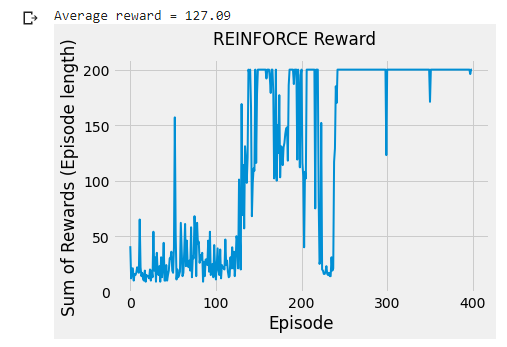

Average reward = 112.2325


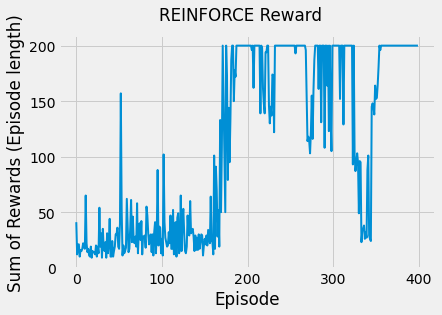

In [7]:
rewards_REINFORCE = REINFORCE_agent.total_rewards

fig1 = plt.figure()
ax1 = fig1.gca()
fig1.suptitle('REINFORCE Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Sum of Rewards (Episode length)')
ax1.plot(rewards_REINFORCE, lw=2)

print('Average reward = ' + str(np.mean(REINFORCE_agent.total_rewards)))

# DQN

## Value Network keras model

In [8]:


# Build keras model to approximate Q(s,a)
dqn_model = Sequential()
dqn_model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
dqn_model.add(Dense(16, activation="relu"))
dqn_model.add(Dense(16, activation="relu"))
dqn_model.add(Dense(16, activation="relu"))
dqn_model.add(Dense(env.action_space.n, activation="linear"))
print(dqn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
None


## Criação e compilação de agente keras-rl

In [9]:
# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=15000, window_length=1)
nb_steps = 25000

# LinearAnnealedPolicy is the function that determines dexay and EpsGreedyQPolicy is the epsilon greedy policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.3, value_min=.05, value_test=0,
                              nb_steps=nb_steps)

dqn = DQNAgent(model=dqn_model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy, gamma=0.9)
dqn.compile(Adam(lr=1e-3), metrics=["mean_squared_error"])

In [10]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
train_history = dqn.fit(env, nb_steps=nb_steps, visualize=False, verbose=2)

Training for 25000 steps ...
    10/25000: episode: 1, duration: 0.080s, episode steps:  10, steps per second: 126, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: --, mean_squared_error: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    18/25000: episode: 2, duration: 0.609s, episode steps:   8, steps per second:  13, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000],  loss: 0.452383, mean_squared_error: 0.484576, mean_q: 0.013686, mean_eps: 0.299860
    30/25000: episode: 3, duration: 0.141s, episode steps:  12, steps per second:  85, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.083 [0.000, 1.000],  loss: 0.359768, mean_squared_error: 0.375974, mean_q: 0.164455, mean_eps: 0.299765


/usr/local/lib/python3.7/dist-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    41/25000: episode: 4, duration: 0.163s, episode steps:  11, steps per second:  67, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.269703, mean_squared_error: 0.293461, mean_q: 0.361608, mean_eps: 0.299650
    52/25000: episode: 5, duration: 0.150s, episode steps:  11, steps per second:  74, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: 0.188017, mean_squared_error: 0.218458, mean_q: 0.567188, mean_eps: 0.299540
    71/25000: episode: 6, duration: 0.219s, episode steps:  19, steps per second:  87, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 0.165249, mean_squared_error: 0.223340, mean_q: 0.852412, mean_eps: 0.299390
    81/25000: episode: 7, duration: 0.116s, episode steps:  10, steps per second:  86, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.159

## Teste do agente treinado

In [11]:
# After training is done, we save the final weights.
dqn.save_weights(f'dqn_{ENV_NAME}_weights.h5f', overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
test_history = dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 158.000, steps: 158
Episode 2: reward: 166.000, steps: 166
Episode 3: reward: 126.000, steps: 126
Episode 4: reward: 154.000, steps: 154
Episode 5: reward: 161.000, steps: 161


## Plot DQN Results

### Resultado Esperado

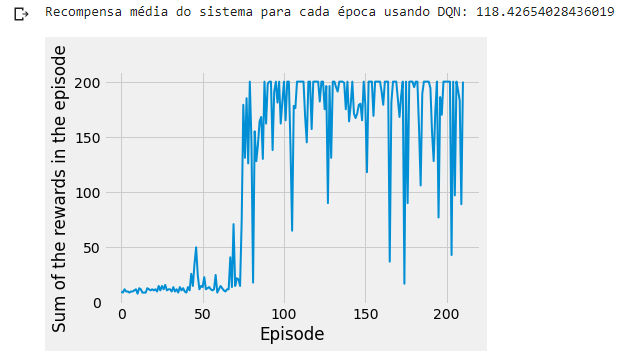

Recompensa média do sistema para cada época usando DQN: 105.16877637130801



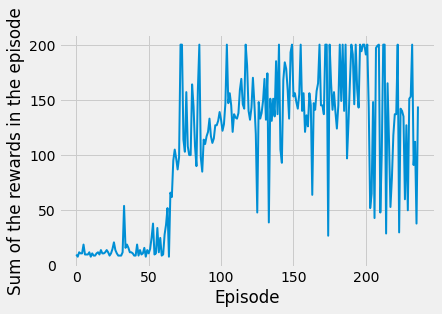

In [12]:
rewards_DQN = train_history.history['episode_reward']
plt.xlabel('Episode')
plt.ylabel('Sum of the rewards in the episode')
plt.plot(rewards_DQN,lw=2)

print("Recompensa média do sistema para cada época usando DQN: " + str(sum(rewards_DQN)/len(rewards_DQN)) )
print()

# REINFORCE - DQN Comparison


### Resultado Esperado

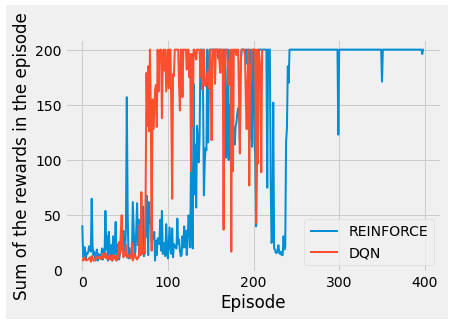

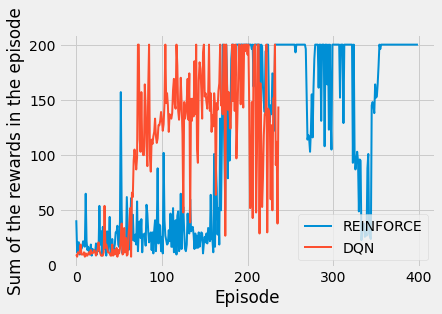

In [13]:
plt.xlabel('Episode')
plt.ylabel('Sum of the rewards in the episode')
plt.plot(rewards_REINFORCE,lw=2,label='REINFORCE')
plt.plot(rewards_DQN,lw=2,label='DQN')
plt.legend(loc='best')
plt.show()

# REINFORCE with Baseline

In [14]:
class REINFORCE_with_Baseline:
  def __init__(self, env):
    self.env=env #import env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.gamma=GAMMA # decay rate of past observations
    self.alpha=ALPHA # learning rate in the policy gradient
    self.learning_rate=0.01 # learning rate in deep learning optimizer

    self.actor_model=self._create_actor_model() # Actor
    self.critic_model=self._create_critic_model() # Critic

    # record observations
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]
  


  def _create_actor_model(self):
    ''' builds the model using keras'''
    # Build Model pi_theta
    model=Sequential()
    # Input Layer and Hidden Layers
    model.add(Dense(16, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(16, activation="relu"))
    # Output Layer
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(lr=self.learning_rate))
        
    return model



  def _create_critic_model(self):
    ''' builds the model using keras'''
    # Build Model pi_theta
    model=Sequential()
    # Input Layer and Hidden Layers
    model.add(Dense(16, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(16, activation="relu"))
    # Output Layer
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(1, activation="linear")) 
    model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        
    return model

  def hot_encode_action(self, action):
    '''encoding the actions into a binary list'''

    action_encoded=np.zeros(self.action_shape, np.float32)
    action_encoded[action]=1

    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    '''stores observations'''
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  
  def get_action(self, state):
    '''samples the next action based on the policy probabilty distribution 
      of the actions'''

    # transform state
    state=state.reshape([1, state.shape[0]])
    # get action probably
    action_probability_distribution=self.actor_model.predict(state).flatten()
    # norm action probability distribution
    action_probability_distribution/=np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution


  def get_discounted_rewards(self, rewards): 
    '''Use gamma to calculate the total reward discounting for rewards
    Following - \gamma ^ t * Gt'''
    
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards


  def update_policy_and_value_function(self):
    '''Updates the policy and value networks
    This function is used after the MC sampling is done - following
    \delta \theta = \alpha * gradient + log pi'''
    
    # Update Actor
    # get X
    states=np.vstack(self.states)

    # get Y
    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    A = (discounted_rewards - self.critic_model.predict(states)) # Advantage = Gt - baseline
    gradients*=A
    gradients=self.probs + self.alpha*np.vstack([gradients])
    
    # Update Actor
    history=self.actor_model.train_on_batch(states, gradients)

    # Update Critic
    self.critic_model.train_on_batch(states, np.vstack(discounted_rewards))
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

    return history



  def simulate_N_episodes(self,N_episodes):

      episode_rewards = []
      for episode in range(N_episodes):

        state = env.reset()
        done = False          
        episode_reward = 0 # record episode reward

        while not done:
            # play an action and record the game state & reward per episode
            action, prob = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            self.remember(state, action, prob, reward)
            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
      
      return np.mean(episode_rewards)



  def train(self, episodes, rollout_n=1):
    '''train the model
        episodes - number of training iterations 
        rollout_n- number of episodes between policy update''' 
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      print('----------------------------------')
      print('episode = ' + str(episode))

      # Simulate rollout_n episodes
      total_episode_reward = self.simulate_N_episodes(N_episodes=rollout_n)

      # Update Policy and Value Networks
      self.update_policy_and_value_function()

      total_rewards[episode] = total_episode_reward
      print('Total Reward = ' + str(total_episode_reward))
      
    self.total_rewards = total_rewards

  def save_model(self):
    '''saves the moodel // do after training'''
    self.model.save('REINFORCE_model.h5')
  

## Create Agent and Learn

In [15]:
REINFORCE_baseline_agent = REINFORCE_with_Baseline(env)
REINFORCE_baseline_agent.train(N_EPISODES, rollout_n=1)

----------------------------------
episode = 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Total Reward = 16.0
----------------------------------
episode = 1
Total Reward = 10.0
----------------------------------
episode = 2
Total Reward = 26.0
----------------------------------
episode = 3
Total Reward = 18.0
----------------------------------
episode = 4
Total Reward = 12.0
----------------------------------
episode = 5
Total Reward = 29.0
----------------------------------
episode = 6
Total Reward = 13.0
----------------------------------
episode = 7
Total Reward = 28.0
----------------------------------
episode = 8
Total Reward = 37.0
----------------------------------
episode = 9
Total Reward = 11.0
----------------------------------
episode = 10
Total Reward = 18.0
----------------------------------
episode = 11
Total Reward = 101.0
----------------------------------
episode = 12
Total Reward = 53.0
----------------------------------
episode = 13
Total Reward = 9.0
----------------------------------
episode = 14
Total Reward = 10.0
----------------------------------
ep

## Plot Results: REINFORCE with Baseline

### Resultado Esperado

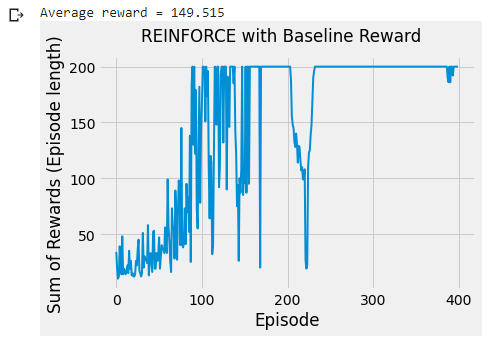

Average reward = 130.2425


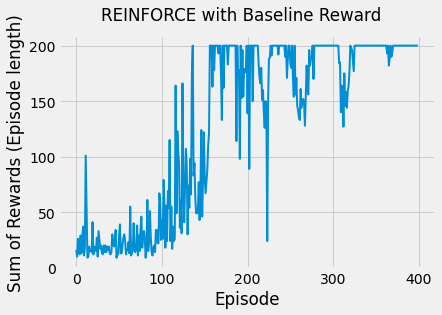

In [16]:
rewards_REINFORCE_baseline = REINFORCE_baseline_agent.total_rewards

fig1 = plt.figure()
ax1 = fig1.gca()
fig1.suptitle('REINFORCE with Baseline Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Sum of Rewards (Episode length)')
ax1.plot(rewards_REINFORCE_baseline, lw=2)

print('Average reward = ' + str(np.mean(REINFORCE_baseline_agent.total_rewards)))

# REINFORCE - REINFORCE_Baseline Comparison


### Resultado Esperado

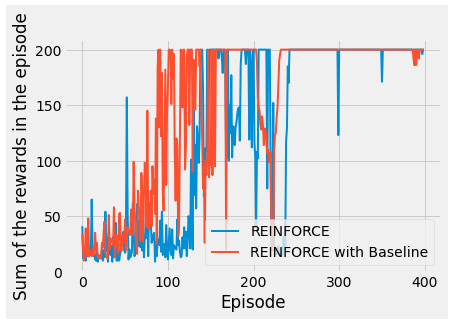

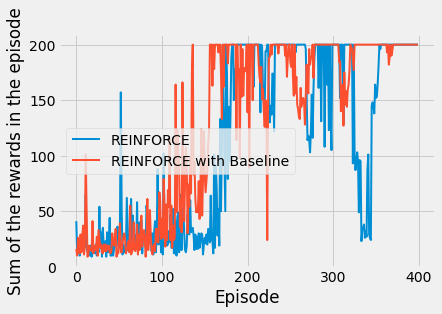

In [17]:
plt.xlabel('Episode')
plt.ylabel('Sum of the rewards in the episode')
plt.plot(rewards_REINFORCE,lw=2,label='REINFORCE')
plt.plot(rewards_REINFORCE_baseline,lw=2,label='REINFORCE with Baseline')
plt.legend(loc='best')
plt.show()

# Actor-Critic Policy Gradient

In [18]:
class One_step_Actor_Critic:
  def __init__(self, env):
    self.env=env #import env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.gamma=GAMMA # decay rate of past observations
    self.alpha=ALPHA # learning rate in the policy gradient
    self.learning_rate_actor=0.01 # learning rate in deep learning optimizer
    self.learning_rate_critic=0.005 # learning rate in deep learning optimizer

    self.actor_model=self._create_actor_model() # Actor
    self.critic_model=self._create_critic_model() # Critic

    # record observations
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]
  


  def _create_actor_model(self):
    ''' builds the model using keras'''
    # Build Model pi_theta
    model=Sequential()
    # Input Layer and Hidden Layers
    model.add(Dense(16, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(16, activation="relu"))
    # Output Layer
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(lr=self.learning_rate_actor))
        
    return model



  def _create_critic_model(self):
    ''' builds the model using keras'''
    # Build Model pi_theta
    model=Sequential()
    # Input Layer and Hidden Layers
    model.add(Dense(32, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    # Output Layer
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(1, activation="linear", kernel_initializer='zeros')) 
    model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate_critic))
        
    return model

  def hot_encode_action(self, action):
    '''encoding the actions into a binary list'''

    action_encoded=np.zeros(self.action_shape, np.float32)
    action_encoded[action]=1

    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    '''stores observations'''
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  
  def get_action(self, state):
    '''samples the next action based on the policy probabilty distribution 
      of the actions'''

    # transform state
    state=state.reshape([1, state.shape[0]])
    # get action probabilities
    action_probability_distribution=self.actor_model.predict(state).flatten()
    # norm action probability distribution
    action_probability_distribution/=np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution


  def get_discounted_rewards(self, rewards): 
    '''Use gamma to calculate the total reward discounting for rewards
    Following - \gamma ^ t * Gt'''
    
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards


  def update_policy_and_value_function(self):
    '''Updates the policy and value networks
    This function is used after the MC sampling is done - following
    \delta \theta = \alpha * gradient + log pi'''
    
    # Update Actor
    # get X
    states=np.vstack(self.states)

    # get Y
    state_values = self.critic_model.predict(states)
    future_V = np.zeros((len(self.states),1))
    for i in range(len(self.states)-1):
        future_V[i,0] = state_values[i+1,0]

    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards) # Calculate returns Gt

    current_V = self.critic_model.predict(states)
    TD_error = (rewards+self.gamma*future_V - current_V) # R_t+1 + gamma*V_theta(S_t+1) - V_theta(S_t)
    gradients*=TD_error
    gradients=self.probs + self.alpha*np.vstack([gradients])
    
    # Update Actor
    history=self.actor_model.train_on_batch(states, gradients)

    # Update Critic
    Y = np.vstack(rewards+self.gamma*future_V)
    # Normalize Expected Returns
    #mean_returns=np.mean(Y)
    #std_returns=np.std(Y)
    #norm_returns=(Y-mean_returns)/(std_returns+1e-7) # avoiding zero div
    self.critic_model.train_on_batch(states, Y)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

    return history



  def simulate_N_episodes(self,N_episodes):

      episode_rewards = []
      for episode in range(N_episodes):

        state = env.reset()
        done = False          
        episode_reward = 0 # record episode reward

        while not done:
            # play an action and record the game state & reward per episode
            action, prob = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            self.remember(state, action, prob, reward)
            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
      
      return np.mean(episode_rewards)



  def train(self, episodes):
    '''train the model
        episodes - number of training iterations 
        rollout_n- number of episodes between policy update''' 
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      print('----------------------------------')
      print('episode = ' + str(episode))

      # Simulate 1 episode
      total_episode_reward = self.simulate_N_episodes(N_episodes=1)

      # Update Policy and Value Networks
      self.update_policy_and_value_function()

      total_rewards[episode] = total_episode_reward
      print('Total Reward = ' + str(total_episode_reward))
      
    self.total_rewards = total_rewards

  def save_model(self):
    '''saves the moodel // do after training'''
    self.model.save('REINFORCE_model.h5')

## Create Agent and Learn

In [19]:
One_step_Actor_Critic_agent = One_step_Actor_Critic(env)
One_step_Actor_Critic_agent.train(1000)

----------------------------------
episode = 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Total Reward = 13.0
----------------------------------
episode = 1
Total Reward = 17.0
----------------------------------
episode = 2
Total Reward = 11.0
----------------------------------
episode = 3
Total Reward = 11.0
----------------------------------
episode = 4
Total Reward = 16.0
----------------------------------
episode = 5
Total Reward = 12.0
----------------------------------
episode = 6
Total Reward = 18.0
----------------------------------
episode = 7
Total Reward = 29.0
----------------------------------
episode = 8
Total Reward = 15.0
----------------------------------
episode = 9
Total Reward = 22.0
----------------------------------
episode = 10
Total Reward = 22.0
----------------------------------
episode = 11
Total Reward = 18.0
----------------------------------
episode = 12
Total Reward = 15.0
----------------------------------
episode = 13
Total Reward = 13.0
----------------------------------
episode = 14
Total Reward = 19.0
----------------------------------
ep

## Plot Results: One-step Actor-Critic

Average reward = 91.227


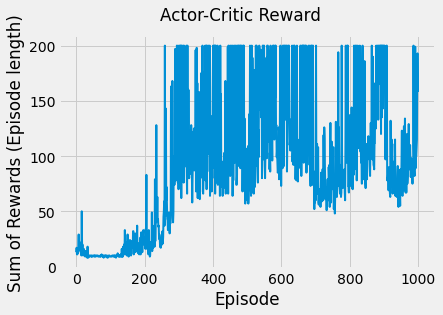

In [20]:
rewards_Actor_critic = One_step_Actor_Critic_agent.total_rewards

fig1 = plt.figure()
ax1 = fig1.gca()
fig1.suptitle('Actor-Critic Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Sum of Rewards (Episode length)')
ax1.plot(rewards_Actor_critic, lw=2)

print('Average reward = ' + str(np.mean(rewards_Actor_critic)))